In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm

## Load Data

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

## Functions

In [4]:
def quadratic_model(x, a, b, c):
    return a*x**2 + b*x + c

def cubic_model(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

initial_guess = {quadratic_model: [1, 1, 0], cubic_model: [1, 1, 1, 0]}

## Analysis

(array([ 1.,  1., 45., 36., 29., 27., 19., 15., 14., 27., 19., 22., 20.,
        13., 17., 11., 16., 20., 15., 14., 10., 14.,  7., 13.,  7.,  5.,
         2.,  8.,  7.,  4.,  7.,  2.,  3.,  5.,  4.,  6.,  0.,  3.,  2.,
         0.,  1.,  2.,  4.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.]),
 array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
        11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
        24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.,
        37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.,
        50., 51., 52., 53., 54., 55.]),
 <BarContainer object of 57 artists>)

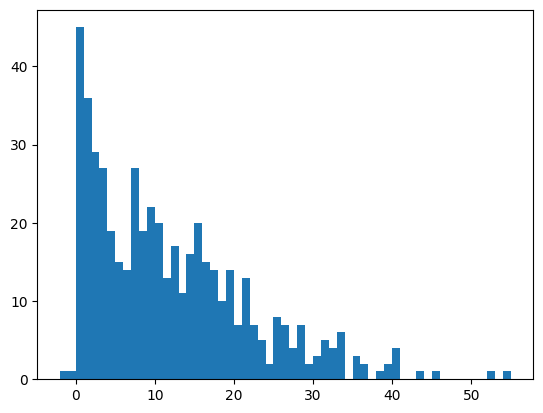

In [5]:
dzdur_min = df.dzdur.min().round()
dzdur_max = df.dzdur.max().round()
# nbins = int((dzdur_max - dzdur_min) / 2) + 2
nbins = int(dzdur_max - dzdur_min) + 1
bins = np.linspace(dzdur_min, dzdur_max, nbins)
plt.hist(df.dzdur, bins=bins)

In [12]:
model_data = df.join([df_thomas_z])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data = model_data[model_data.dzdur <= 32]
model_data['dzdur_bin'] = np.digitize(model_data['dzdur'], bins)
numeric_cols = model_data.select_dtypes("number").columns

model_data2 = pd.DataFrame()
rows = []
inds = []
for bin in model_data.dzdur_bin.unique():
    data_to_concat = model_data[model_data.dzdur_bin == bin]
    rows.append(data_to_concat[numeric_cols].mean())
    inds.append(bin)
model_data2 = pd.DataFrame(rows, index=inds)
model_data2.sort_index(inplace=True)

AV_2
[0.220430411313427, 0.10943169393783769, 0.023126420199169107]
Pul_8
[0.06262309536210398, 0.28606382884197024, 0.03323371703724076]


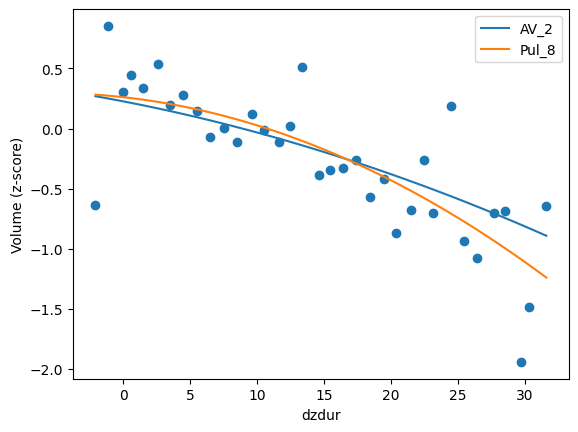

In [14]:
struct_ind = 2
struct_name = hips_thomas_ref[struct_ind]
print(struct_name)
x_data = model_data2.dzdur
y_data = model_data2[struct_name]

model = quadratic_model

popt, pcov = curve_fit(model, x_data, y_data, p0=initial_guess[model])
x_model = np.linspace(x_data.min(), x_data.max(), 100)
y_model = model(x_model, *popt)

n = len(y_data)
p = len(popt)
stderr = np.sqrt(np.diag(pcov))
t_stats = popt / stderr
p_vals = [(1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
print(p_vals)

# plt.scatter(model_data2.dzdur, model_data2[struct_name])
plt.plot(x_model, y_model, label=struct_name)

struct_ind = 8
struct_name = hips_thomas_ref[struct_ind]
print(struct_name)
x_data = model_data2.dzdur
y_data = model_data2[struct_name]

model = quadratic_model

popt, pcov = curve_fit(model, x_data, y_data, p0=initial_guess[model])
x_model = np.linspace(x_data.min(), x_data.max(), 100)
y_model = model(x_model, *popt)

n = len(y_data)
p = len(popt)
stderr = np.sqrt(np.diag(pcov))
t_stats = popt / stderr
p_vals = [(1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
print(p_vals)

plt.scatter(model_data2.dzdur, model_data2[struct_name])
plt.plot(x_model, y_model, label=struct_name)

plt.xlabel("dzdur")
plt.ylabel("Volume (z-score)")
plt.legend()

In [15]:
perr = np.sqrt(np.diag(pcov))
alpha = 0.05
dof = max(0, len(x_data) - len(popt))  # degrees of freedom
tval = stats.t.ppf(1.0 - alpha / 2., dof)

ci = [(p - tval * err, p + tval * err) for p, err in zip(popt, perr)]

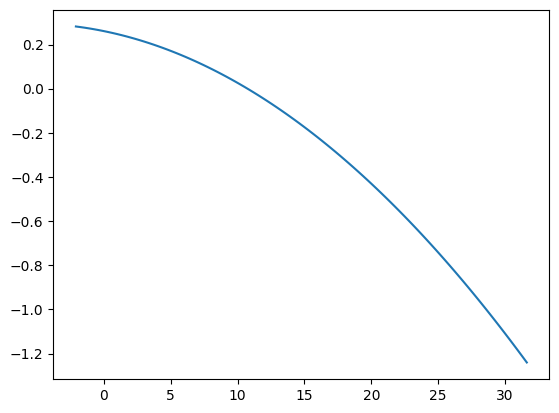

In [17]:
lower_params = [item[0] for item in ci]
y_lower = model(x_model, *lower_params)

upper_params = [item[1] for item in ci]
y_upper = model(x_model, *upper_params)

plt.plot(x_model, y_model)
# plt.fill_between(x_model, y_lower, y_upper, alpha=0.2)